# Summary of this notebook
High level: 
read image; 
read scene; 
read question;
- 3 methods to read the scenes (same as methods defined in scenegraph_stats): get names, get scene, get object counts
    - how to read scenegraph: json file
        - dictionaries
- display image method
    - how to read images: 
        - multiple ways: I am using cv2 package
        - define image_path, then use cv2 to read it. 
- display image method with labels (names) and rectangles (interplay of image and objects in the scenegraph)

In [ ]:
import cv2
import json
import numpy as np
import random
from pathlib import Path
from collections import Counter
from nltk.stem import WordNetLemmatizer
import re
import seaborn as sns

Matplotlib is building the font cache; this may take a moment.


In [ ]:
def get_object_names(scenegraph):
    names = {}
    for key, val in scenegraph.items():
        names[key] = val['name']
    return names
# scene_id need to be str
def get_scene_graph(scene_id):
    return d[scene_id]['objects']
def get_object_count(scenegraph):
    return len(scenegraph)

# color generator 
def generate_bgr_colors(num_colors):
    # Generate a list of `num_colors` distinct colors using a colormap
    colormap = plt.cm.get_cmap('hsv', num_colors)
    colors_rgb = [colormap(i)[:3] for i in range(num_colors)]
    
    # Convert RGB to BGR and scale from 0-1 to 0-255
    colors_bgr = [(int(r * 255), int(g * 255), int(b * 255)) for r, g, b in colors_rgb]
    return colors_bgr

# Function to draw a rectangle
def draw_rectangle(img, top_left, bottom_right, color, thickness):
    cv2.rectangle(img, top_left, bottom_right, color, thickness)
    
# function to get list of rectangle values 
# rectangles: a list of tuples,
# each tuple contains 2 data points that are also invidually represented as a tuple
def get_rectagle_values(scene):
    rectangles = []
    labels = []
    for key, item in scene.items():
        val = ((item['x'], item['y']), 
           (item['x']+item['w'], item['y']+item['h']))
        label = f"{item['name']}: {key}"
        labels.append(label)
        rectangles.append(val)
    # if item['name'] == "air":
    #     labels.append(label)
    #     rectangles.append(val)
        objs_len = 1
    return rectangles, labels

def display_original_image(img):
    # # Convert BGR to RGB for proper display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image with the rectangles
    plt.imshow(img_rgb)
    # plt.axis('off')  # Hide axes
    plt.show()

def display_image_with_labels(objs_len, rectangles, img, labels):
    # Define colors (BGR format)
    colors = generate_bgr_colors(objs_len)

    # Thickness of the rectangles
    thickness = 2

    # Draw the rectangles
    for i in range(objs_len):
        top_left, bottom_right = rectangles[i]
        color = colors[i]
        draw_rectangle(img, top_left, bottom_right, color, thickness)

    # # Convert BGR to RGB for proper display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image with the rectangles
    plt.imshow(img_rgb)
    # plt.axis('off')  # Hide axes
    plt.show()

    # Convert BGR to RGB
    colors_rgb = [tuple(reversed(color)) for color in colors]  # Reverse each BGR tuple to get RGB

    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(8, 6))

    # Remove the axes
    ax.axis('off')

    # Create a grid of color patches with labels
    for i, (color, label) in enumerate(zip(colors_rgb, labels)):
        rect = plt.Rectangle((0, i), 1, 1, color=np.array(color) / 255)
        ax.add_patch(rect)
        ax.text(1.5, i + 0.5, label, va='center', ha='left', fontsize=12)

    # Set limits and aspect ratio to make the grid uniform
    ax.set_xlim(0, 2.5)
    ax.set_ylim(0, len(colors_rgb))
    ax.set_aspect('equal')

    # Display the colors with labels
    plt.show()

In [ ]:
# load the scenegraph
def load_scenegraphs(split):
    path = f"../data/sceneGraphs/{split}_sceneGraphs.json"
    with open(path) as f:
        d = json.load(f)
    return d
def get_image_path(img_id):
    return f"../../data/gqa/data/images/{img_id}.jpg" 
def sample_ids(n):
    return random.sample(list(d.keys()), n)

In [ ]:
d = load_scenegraphs('val')

In [ ]:
ids

In [ ]:
# Load the image
# TODO: make scenegraphs a class
# How to load a class from jupyter notebook? 
for item in ids:
    image_path = get_image_path(item) 
    img = cv2.imread(image_path)
    scene = get_scene_graph(item)
    objs_len = get_object_count(scene)
    print(objs_len)
    rectangles, labels = get_rectagle_values(scene)
    display_original_image(img)
    display_image_with_labels(objs_len, rectangles, img, labels)

# Combinations of questions, image and scenes
- up till here, we have loaded images and scenegraphs
- next step is to load questions
- ['2375429'] as an example: the horse
- ['3523'] as an example: few objects

In [1]:
# balanced
# val
# train
def load_train_questions(n):
    path = f"../../data/gqa/data/train_all_questions/train_all_questions_{n}.json"
    with open(path) as f:
        questions = json.load(f)
    return questions
def load_val_questions(ifBalanced):
    path = Path("../../data/gqa/data/")
    if ifBalanced:
        path = path / 'val_balanced_questions.json'
    else:
        path = path / 'val_all_questions.json'
    with open(path) as f:
        questions = json.load(f)
    return questions   

In [5]:
questions = load_train_questions(0)

KeyboardInterrupt: 

In [ ]:
counter = 0
for key, val in questions.items():
    if counter < 1:
        semantic = val.get('semantic', [])
        print(semantic)
        print(val)
        counter += 1
    else:
        break

In [ ]:
# introduce the lemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
for key, val in questions.items():
    print(key)
    print(val)
    break

### This following code is calculating: if argument does not include an object id, and the question and answer includes 0 values, how many questions are left

In [53]:
# this method needs some revision: but basically the reason why we gets duplicates, it's because 
# there may be multiple select (whenever there are more than one, 
# it will add to the list, so duplicates can been seen), need a way to deal with this. 
count = 0
category = []
img_ids = []
ls_questions = set()
answers = []
obj_count = 0
count_total_questions = 0
questions_for_match_case_set = set()
for key, value in questions.items():
    question = value.get('question', '')
    semantics = value.get('semantic', [])
    imgid = value.get('imageId')
    flag = False
    for operation in semantics: 
        if operation['operation'] == 'select':
            noun = operation['argument']
            match = re.search(r'\(([\d,]+)\)', noun)
            if match or flag:
                # number = int(match.group(1))
                if match:
                    numbers = [int(num) for num in match.group(1).split(',')]
                    # print(number)
                    count_total_questions += 1
                if question not in questions_for_match_case_set:
                    questions_for_match_case_set.add(question)
                flag = True

    if not flag:
        if len(value['annotations']['question'].values()) != 0:
            img_ids.append(key)
                    # if question not in ls_questions:
                    #     ls_questions.add(question)
                    # # print(question)
                    # # print(noun)
                    # # print(value['annotations']['question'].values())
                    # obj_count += 1
                    # category.append(value['types']['semantic'])
                    # answers.append(value['answer'])
                # else:
                #     print(key)
                #     print("not match: ", value) 
            # print(operation['argument'])
            # print(question)
            # print(imgid)
            # print(get_object_names(get_scene_graph(imgid)))

In [42]:
noun = questions['11414711']
print(noun)

{'semantic': [{'operation': 'select', 'dependencies': [], 'argument': 'bus (2785222)'}, {'operation': 'filter size', 'dependencies': [0], 'argument': 'not(large)'}, {'operation': 'exist', 'dependencies': [1], 'argument': '?'}, {'operation': 'select', 'dependencies': [], 'argument': 'truck (-) '}, {'operation': 'filter size', 'dependencies': [3], 'argument': 'not(large)'}, {'operation': 'exist', 'dependencies': [4], 'argument': '?'}, {'operation': 'or', 'dependencies': [2, 5], 'argument': ''}], 'entailed': ['11414727', '11414730', '11414728', '11414729'], 'equivalent': ['11414711'], 'question': 'Are there trucks or buses that are not large?', 'imageId': '2415503', 'isBalanced': False, 'groups': {'global': None, 'local': '04-bus_n#large'}, 'answer': 'no', 'semanticStr': 'select: bus (2785222)->filter size: not(large) [0]->exist: ? [1]->select: truck (-) ->filter size: not(large) [3]->exist: ? [4]->or:  [2, 5]', 'annotations': {'answer': {}, 'question': {'4': '2785222'}, 'fullAnswer': {'4

In [52]:
print(len(img_ids))

385563


In [39]:
print(len(questions))

2011853


In [55]:
print(385563 / len(questions))

0.19164571168967118


In [ ]:
print(obj_count)
print(len(ls_questions))
print(len(category))
print(len(questions))
print(len(questions_for_match_case_set))
print(count_total_questions)
print(len(questions))

In [ ]:
print(answers[:20000])count_total_questions

In [ ]:
556924 / 2011853
# 70% of the questions

In [ ]:
# Plotting the histogram
plt.figure(figsize=(8, 6))
sns.histplot(category, kde=False, bins=5)  # kde=False removes the kernel density estimate

# Adding labels and title
plt.xlabel('category')
plt.ylabel('Frequency')
plt.title('Frequency Distribution')

# Show the plot
plt.show()

In [ ]:
for id_name, question, cat, answer in zip(img_ids[:20], ls_questions[:20], category[:20], answers[:20]):
    scene = get_scene_graph(id_name)
    names = get_object_names(scene)
    print(names)
    print(question)
    image_path = get_image_path(id_name) 
    print(image_path)
    print(cat)
    print(answer)
    img = cv2.imread(image_path)
    rectangles, labels = get_rectagle_values(scene)
    display_original_image(img)
    display_image_with_labels(len(names), rectangles, img, labels)

In [ ]:
print(questions['05451384'])

In [ ]:
print(questions['05451386'])

In [ ]:
print(questions['05451385'])

In [ ]:
def get_all_questions_counts(img_id, questions):
    count = 0
    for key, val in questions.items():
        if val['imageId'] == img_id:
            count+= 1
    return count

def get_all_questions(keys, questions):
    for key in keys:
        print(questions[key])
        
def get_object_ids_in_question(q_id, questions):
    print(questions[q_id]['question'])
    print(questions[q_id]['answer'])
    return list(questions[q_id]['annotations']['question'].values())

In [ ]:
# print(count)
# get_all_questions(keys, questions)
# object_ids = []
# for key in keys:
#     object_ids.extend(get_object_ids_in_question(key, questions))
# print(object_ids)
counts = []
for key in d.keys():
    counts.append(get_all_questions_counts(key, questions))

In [ ]:
print(counts)

In [ ]:
# object: present in questions how many times; present in answers how many times? in total how many times? 
# show that for just 1 image
# just get the object keys, for each object in the scene, 
# how many times does it show up in the questions? How many times does it show up in the answers? How many times does it show up in the fullanswers? 
# scene = get_scene_graph('3523')
# object_keys = list(scene.keys())
# counter = Counter(object_ids)
# print(counter)
# names = get_object_names(scene)

In [ ]:
# for key, val in counter.items():
#     print(f"{key} - {names.get(key)}: {val}")

# load the hypernyms

In [ ]:
with open('../data/gqa_entities/noun-hypernyms.json') as f:
    hyper = json.load(f)
print(len(hyper))

In [ ]:
count = 0
for key, value in questions.items():
    if len(value['annotations']['question']) == 0:
        count += 1
        if count < 10:
            print(value)
print(count)

In [ ]:
print(len(questions))

In [ ]:
print(count / len(questions))

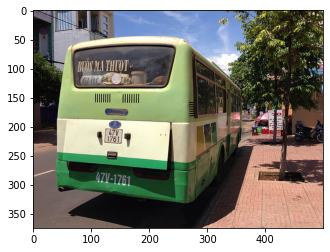

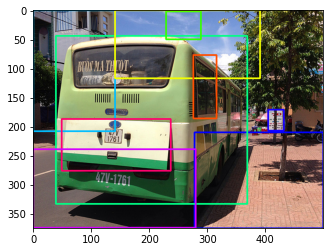

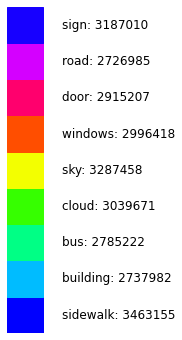

In [37]:
## present image
id_name = '2415503'
scene = get_scene_graph(id_name)
names = get_object_names(scene)
image_path = get_image_path(id_name) 
img = cv2.imread(image_path)
rectangles, labels = get_rectagle_values(scene)
display_original_image(img)
display_image_with_labels(len(names), rectangles, img, labels)

In [ ]:
1167549 (lady),
1167536 (man),
1167544 (woman),
1167551 (man)